In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings
from datetime import datetime
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import random
import catboost as cb

In [3]:
df_raw = pd.read_csv('PNS_0613.csv',encoding='utf-8-sig')

In [345]:
df_raw = pd.read_csv('PNS_0613.csv',encoding='utf-8-sig')
item_list = pd.read_csv('주요리스트.csv',header=None)
df_raw = df_raw.set_index('ts')
df_raw = df_raw.sort_index()

In [346]:
out_feature1 = pd.read_csv("Feature_scouting1.csv",encoding='utf-8')
out_feature2 = pd.read_csv("Feature_scouting2.csv",encoding='ansi')

### Scouted Feature Aggregating

In [347]:
import calendar
# 인덱스를 시간 형태로 변환
out_feature1_t = out_feature1.transpose()
out_feature1_t = out_feature1_t.rename(columns=out_feature1_t.iloc[0]).drop(out_feature1_t.index[0])
#out_feature1_t
# 인덱스를 시간 형태로 변환
out_feature1_t.index = pd.to_datetime(out_feature1_t.index.str.replace('/Q', '-'), format='%Y-%m')
out_feature1_sort = out_feature1_t.sort_index()

# 인덱스 확장
expanded_index = pd.date_range(start=out_feature1_sort.index[0], end=out_feature1_sort.index[-1], freq='MS').union(out_feature1_sort.index)

# 새로운 인덱스 생성 및 할당
#new_index = expanded_index.repeat(3)
expanded_index = pd.date_range(start=out_feature1_sort.index[0], periods=len(out_feature1_sort)*3, freq='MS')

# 새로운 데이터프레임 생성 및 값 할당
feature1 = pd.DataFrame(index=expanded_index)


for column in out_feature1_sort.columns:
    feature1[column] = out_feature1_sort[column].repeat(3).values
feature1.index = feature1.index.to_series().apply(lambda x: x.replace(day=calendar.monthrange(x.year, x.month)[1]))
feature1.columns = ['fabric', 'etc','GDP']
feature1['fabric'] = feature1['fabric'].str.replace(',', '').astype('float64')
feature1['etc'] = feature1['etc'].str.replace(',', '').astype('float64')
feature1['GDP'] = feature1['GDP'].str.replace(',', '').astype('float64')

In [348]:
out_feature2_t = out_feature2.transpose()
feature2 = out_feature2_t.rename(columns=out_feature2_t.iloc[0]).drop(out_feature2_t.index[0])
feature2.index = pd.to_datetime(feature2.index, format='%Y-%m')
feature2 = feature2.sort_index()
feature2.index = feature2.index.to_series().apply(lambda x: x.replace(day=calendar.monthrange(x.year, x.month)[1]))
feature2.columns = ['industry', 'industrial']
feature2 = feature2[feature2.index < '2023-04']

### Original data aggregating

#### 주문 취소 값 상쇄시키기, 이외의 마이너스 값 삭제

In [349]:
df_blank=pd.DataFrame()
# 연속된 두 행의 qty 값이 0인 행 찾기
for item_id in df_raw['primaryItemId'].unique():
    df_item = df_raw[df_raw['primaryItemId'] == item_id]
    condition = (df_item['qty'] + df_item['qty'].shift(-1) == 0)
    zero_sum_rows = df_item[condition]
    df_cleaned = df_item.drop(zero_sum_rows.index)
    df_blank = pd.concat([df_blank, df_cleaned])
df_raw = df_blank[df_blank['qty'] >= 0]
df_raw = df_raw.reset_index()
# 484개 행 제거

In [350]:
#Aggregating 1: year month 추가, Grouping 진행, 범주형 변수들 카테고리화
def processing(df):
    df['ts'] = df['ts'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
    df['year'] = df['ts'].apply(lambda x: x.year)
    df['month'] = df['ts'].apply(lambda x: x.month)
    df['year_month'] = df['ts'].dt.strftime('%Y-%m')
    df['year_month'] = df['year_month'].apply(lambda x: datetime.strptime(x, '%Y-%m'))
   
    df_grouped = df.groupby(['primaryItemId', pd.Grouper(key='year_month', freq='M')]).agg({'qty': 'sum',
        'receiver':'first','category1':'first',
         'category2':'first','category3':'first','status':'first', 'itemNm': 'first',
        'unit':'first','spec':'first','regDt':'first','year':'first','month':'first'}).reset_index()

    #int, float, bool, category
    df_grouped['receiver'] = df_grouped['receiver'].astype('category')
    df_grouped['category2'] = df_grouped['category2'].astype('category')
    df_grouped['category3'] = df_grouped['category3'].astype('category')
    df_grouped['status'] = df_grouped['status'].astype('category')
    df_grouped['unit'] = df_grouped['unit'].astype('category')

    df_grouped = df_grouped.set_index('year_month')
    
    return df, df_grouped

In [351]:
def processing2(df_grouped):

    # 필요한 feature들을 생성
    
    # 1개월전 출고량
    df_grouped['1m_qty'] = df_grouped.groupby('primaryItemId')['qty'].shift(1).fillna(0)

    # 2개월전 출고량
    df_grouped['2m_qty'] = df_grouped.groupby('primaryItemId')['qty'].shift(2).fillna(0)

    # 직전 3개월 평균출고량
    df_grouped['3m_mean'] = df_grouped.groupby('primaryItemId')['qty'].rolling(window=4, min_periods=1).apply(lambda x: np.mean(x[:-1])).reset_index(level=0, drop=True).fillna(0)

    # 직전 6개월 평균출고량
    df_grouped['6m_mean'] = df_grouped.groupby('primaryItemId')['qty'].rolling(window=7, min_periods=1).apply(lambda x: np.mean(x[:-1])).reset_index(level=0, drop=True).fillna(0)
    
    # 전년 동기 출고량
    df_grouped['ly_qty'] = df_grouped.groupby('primaryItemId')['qty'].shift(12).fillna(0)

    # 전년 동기 3개월 출고량
    df_grouped['ly_3m_qty'] = df_grouped.groupby('primaryItemId')['qty'].rolling(window=3, min_periods=1).sum().reset_index(level=0, drop=True).shift(12).fillna(0)
    
    return df_grouped

In [352]:
df_raw, df_raw_grouped = processing(df_raw)

In [353]:
# 12개 이상의 데이터가 있는 primaryItemId 추출
# 출고 기록이 너무 없는 데이터를 학습, 예측시킬 경우, 오히려 예측력이 떨어질 수 있음
#따라서 12달 이상의 출고 기록이 있는 품목만 추림

item_counts = df_raw_grouped['primaryItemId'].value_counts()
valid_items = item_counts[item_counts >= 18].index
df_raw_grouped = df_raw_grouped[df_raw_grouped['primaryItemId'].isin(valid_items)]
df_raw_grouped = df_raw_grouped.reset_index()

## 한 제품에서 폐기, 사용이 있는 경우: 106개

In [354]:
count = 0
for item_id in df_raw_grouped['primaryItemId'].unique():
    df_item = df_raw_grouped[df_raw_grouped['primaryItemId'] == item_id]
    k = df_item['status'].nunique()
    if k !=1:
        count = count+1
print(count)

99


In [355]:
df_filtered = df_raw_grouped.groupby('primaryItemId').filter(lambda x: (x['status'] != '폐기').any())
print(df_raw_grouped['primaryItemId'].nunique())
print(df_filtered['primaryItemId'].nunique())

611
486


## 판매가 없는 Month의 qty를 0으로 채움

In [356]:
def fill_zero(df):
    new_df = pd.DataFrame()
    for i,code in enumerate(df['primaryItemId'].unique()):
        #print(f'{i}/{df['Product_Code'].nunique()}')
        category = df[df['primaryItemId']==code]['category1'].unique()[0]
        #categorial
        category2 = df[df['primaryItemId']==code]['category2'].unique()[0]
        category3 = df[df['primaryItemId']==code]['category3'].unique()[0]
        spec = df[df['primaryItemId']==code]['spec'].unique()[0]
        receiver = df[df['primaryItemId']==code]['receiver'].unique()[0]
        
        tmp_df = df.groupby('primaryItemId').get_group(code)
        
        start_date = tmp_df['year_month'].min()
        end_date = tmp_df['year_month'].max()
        # full range of Date
        date_range = pd.date_range(start=start_date, end=end_date, freq='M')
        date_df = pd.DataFrame(date_range, columns=['year_month'])
        # 기존 데이터와 새로운 DataFrame을 병합하고 qty를 0으로 채웁니다.
        merged_df = pd.merge(date_df, tmp_df, on='year_month', how='left')
        merged_df['qty'].fillna(0, inplace=True)
        merged_df['primaryItemId'].fillna(code, inplace=True)
        merged_df['category1'].fillna(category, inplace=True)
        merged_df['category2'].fillna(category2, inplace=True)
        merged_df['category3'].fillna(category3, inplace=True)
        merged_df['spec'].fillna(spec, inplace=True)
        merged_df['receiver'].fillna(receiver, inplace=True)
        #merged_df['Warehouse'].fillna(method='ffill', inplace=True)
        
        new_df = pd.concat([new_df, merged_df], axis=0, ignore_index=True)

    return new_df

In [357]:
#0으로 채우는 Aggregating 후, Feature Engineering

df_raw_grouped = fill_zero(df_raw_grouped)
df_raw_grouped['year'] = df_raw_grouped['year_month'].apply(lambda x: x.year)
df_raw_grouped['month'] = df_raw_grouped['year_month'].apply(lambda x: x.month)
df_raw_grouped = df_raw_grouped.set_index('year_month')



### Scout한 Feature 병합

In [358]:
for index, row in df_raw_grouped.iterrows():
    if index in feature1.index:
        df_raw_grouped.loc[index, 'fabric'] = feature1.loc[index, 'fabric']
        df_raw_grouped.loc[index, 'etc'] = feature1.loc[index, 'etc']
        df_raw_grouped.loc[index, 'GDP'] = feature1.loc[index, 'GDP']
        df_raw_grouped.loc[index, 'industry'] = feature2.loc[index, 'industry']
        df_raw_grouped.loc[index, 'industrial'] = feature2.loc[index, 'industrial']

In [359]:
#스케일링 하는 방식: minmax로 scaling, 전체 데이터에 대해서 포괄적으로 하는것이 아닌 각 품목마다 나눈 후 품목의 데이터에서 스케일링
df_scaled = pd.DataFrame()
scaler = MinMaxScaler()
for item_id, group_df in df_raw_grouped.groupby('primaryItemId'):
    scaled_qty = scaler.fit_transform(group_df['qty'].values.reshape(-1, 1))
    scaled_fabric = scaler.fit_transform(group_df['fabric'].values.reshape(-1, 1))
    scaled_etc = scaler.fit_transform(group_df['etc'].values.reshape(-1, 1))
    scaled_gdp = scaler.fit_transform(group_df['GDP'].values.reshape(-1, 1))
    scaled_ind = scaler.fit_transform(group_df['industry'].values.reshape(-1, 1))
    scaled_inds = scaler.fit_transform(group_df['industrial'].values.reshape(-1, 1))
    group_df['qty'] = scaled_qty
    group_df['fabric'] = scaled_fabric
    group_df['etc'] = scaled_etc
    group_df['GDP'] = scaled_gdp
    group_df['industry'] = scaled_ind
    group_df['industrial'] = scaled_inds
    df_scaled = pd.concat([df_scaled, group_df])
df_scaled = processing2(df_scaled)

In [360]:
print(len(df_scaled))
print(len(df_raw_grouped))

41439
41439


In [361]:
df_scaled

,primaryItemId,qty,receiver,category1,category2,category3,status,itemNm,unit,spec,...,etc,GDP,industry,industrial,1m_qty,2m_qty,3m_mean,6m_mean,ly_qty,ly_3m_qty
year_month,,,,,,,,,,,,,,,,,,,,,
2015-04-30,1KOKHC0010,0.863636,금호석유화학,상품,[상품]KP BAG,[상품]BBO BAG,사용,금호 KTR-101 가셑형(15KG풀색)-1,PCS,450*750*140,...,0.050325,0.000000,0.161560,0.295699,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-05-31,1KOKHC0010,0.000000,금호석유화학,상품,[상품]KP BAG,[상품]BBO BAG,NaN,NaN,NaN,450*750*140,...,0.050325,0.000000,0.116992,0.190860,0.863636,0.000000,0.863636,0.863636,0.000000,0.000000
2015-06-30,1KOKHC0010,0.590909,금호석유화학,상품,[상품]KP BAG,[상품]BBO BAG,사용,금호 KTR-101 가셑형(15KG풀색)-1,PCS,450*750*140,...,0.050325,0.000000,0.222841,0.298387,0.000000,0.863636,0.431818,0.431818,0.000000,0.000000
2015-07-31,1KOKHC0010,0.409091,금호석유화학,상품,[상품]KP BAG,[상품]BBO BAG,사용,금호 KTR-101 가셑형(15KG풀색)-1,PCS,450*750*140,...,0.176766,0.039630,0.139276,0.271505,0.590909,0.000000,0.484848,0.484848,0.000000,0.000000
2015-08-31,1KOKHC0010,0.409091,금호석유화학,상품,[상품]KP BAG,[상품]BBO BAG,사용,금호 KTR-101 가셑형(15KG풀색)-1,PCS,450*750*140,...,0.176766,0.039630,0.080780,0.126344,0.409091,0.590909,0.333333,0.465909,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-11-30,2SWYSC0020,0.000000,용산화학울산공장,제품,[제품]PP BAG,[제품]SW BAG,NaN,NaN,NaN,50*78,...,0.542470,0.933284,0.622754,0.604839,0.658905,0.653799,0.547913,0.550204,0.000000,1.314970
2022-12-31,2SWYSC0020,0.330934,용산화학울산공장,제품,[제품]PP BAG,[제품]SW BAG,사용,용산화학 MLA.25KG 지대(FS)-2,PCS,50*78,...,0.542470,0.933284,1.000000,0.655914,0.000000,0.658905,0.437568,0.495413,0.328743,0.657485
2023-01-31,2SWYSC0020,0.652778,용산화학울산공장,제품,[제품]PP BAG,[제품]SW BAG,사용,용산화학 MLA.25KG 지대(FS)-2,PCS,50*78,...,1.000000,1.000000,0.401198,0.303763,0.330934,0.000000,0.329946,0.495779,0.654048,0.982791


### 실제 테스트 대상이 될 데이터

In [362]:
#스케일링 된 테스트 대상 데이터
df_grouped = df_scaled[df_scaled['primaryItemId'].apply(lambda x: any(i == x for i in item_list[0]))]
df_grouped = df_grouped[df_grouped['category1']=='제품']
df_grouped = df_grouped.groupby('primaryItemId').filter(lambda x: (x['status'] != '폐기').any())

#스케일링이 안 된 테스트 대상 데이터
df_grouped_raw = df_raw_grouped[df_raw_grouped['primaryItemId'].apply(lambda x: any(i == x for i in item_list[0]))]
df_grouped_raw = df_grouped_raw[df_grouped_raw['category1']=='제품']
df_grouped_raw = df_grouped_raw.groupby('primaryItemId').filter(lambda x: (x['status'] != '폐기').any())

In [363]:
print(df_grouped['primaryItemId'].nunique())
print(len(df_grouped_raw))

211
15358


## XGBOOST 모델링

In [364]:
random.seed(12345)

## 1. 전체 데이터 중 23년 2월까지의 데이터를 학습시켜 품목들의 23년 3월의 값을 예측

In [365]:
# 모델링 함수
def xgboost_month(df_raw, df, df_origin, train_end, val_end, test_end, df_xgb, cols):# 각각 Train, test, test 스케일 안된 df, 날짜 범위1,2
    df_raw_grouped = df_raw.query("index < @train_end")
    df_raw_grouped = df_raw_grouped.sort_values(by='year_month')
    
    #X_train = df_raw_grouped[cols[:-1]]  # 마지막 열인 'qty'는 target column으로 분리
    #y_train = df_raw_grouped['qty']

    #X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
    
    train = df_raw_grouped.query("index < @val_end")
    val = df_raw_grouped.query("index >= @val_end")
    
    X_train = train[cols[:-1]]  # 마지막 열인 'qty'는 target column으로 분리
    y_train = train['qty']
    X_val = val[cols[:-1]]
    y_val = val['qty']
    
    df_grouped = df.query("@train_end <= index < @test_end")
    df_grouped_raw = df_origin.query("@train_end <= index < @test_end")
    for item_id in df_grouped['primaryItemId'].unique():

    # 해당 primaryItemId에 대한 데이터 추출
        df_item = df_grouped[df_grouped['primaryItemId'] == item_id]
        df_item_origin_value = df_grouped_raw[df_grouped_raw['primaryItemId']== item_id]
    #if len(df_item) <= 10:
    #   continue

    # feature 추출
        X_test = df_item[cols[:-1]]  # 마지막 열인 'qty'는 target column으로 분리
        y_test = df_item['qty']

    # XGBoost 모델 초기화
        xg_reg = xgb.XGBRegressor(objective='reg:squarederror', 
                              colsample_bytree=0.8, 
                              learning_rate=0.05,
                              max_depth=12, 
                              alpha=2, 
                              n_estimators=300)

    # 모델 학습
        xg_reg.fit(X_train, y_train, eval_set=[(X_val, y_val)], early_stopping_rounds=10, verbose=False)
    # 모델 예측
        y_pred = xg_reg.predict(X_test)

        nrmse = np.sqrt(np.mean((y_pred - y_test) ** 2))
        
        min_value = df_origin[df_origin['primaryItemId']== item_id]['qty'].min()
        max_value = df_origin[df_origin['primaryItemId']== item_id]['qty'].max()


        # 역변환을 통해 스케일링 이전의 예측값 얻기
        original_pred = (y_pred * (max_value - min_value)) + min_value
    
        result = pd.DataFrame({'primaryItemId': item_id, 'actual': df_item_origin_value['qty'].values, 'pred': original_pred, 'scale_actual': y_test.values,'scale_pred': y_pred, 'nrmse': nrmse, 'date': df_item.index}, index=[0])
        df_xgb = pd.concat([df_xgb, result], ignore_index=True)
    
    return df_xgb


### Catboost 모델링

In [366]:
def catboost_month(df_raw, df, df_origin, train_end, val_end, test_end, df_catboost, cols):
    df_raw_grouped = df_raw.query("index < @train_end")
    df_raw_grouped = df_raw_grouped.sort_values(by='year_month')

    train = df_raw_grouped.query("index < @val_end")
    val = df_raw_grouped.query("index >= @val_end")

    X_train = train[cols[:-1]]  # 마지막 열인 'qty'는 target column으로 분리
    y_train = train['qty']
    X_val = val[cols[:-1]]
    y_val = val['qty']

    df_grouped = df.query("@train_end <= index < @test_end")
    df_grouped_raw = df_origin.query("@train_end <= index < @test_end")

    for item_id in df_grouped['primaryItemId'].unique():
        # 해당 primaryItemId에 대한 데이터 추출
        df_item = df_grouped[df_grouped['primaryItemId'] == item_id]
        df_item_origin_value = df_grouped_raw[df_grouped_raw['primaryItemId'] == item_id]

        # feature 추출
        X_test = df_item[cols[:-1]]  # 마지막 열인 'qty'는 target column으로 분리
        y_test = df_item['qty']

        # CatBoost 모델 초기화
        cat_reg = cb.CatBoostRegressor(iterations=300, depth=12, learning_rate=0.05, loss_function='RMSE')

        # 범주형 변수 지정
        cat_features = ['category2', 'category3', 'receiver', 'spec']

        # 모델 학습
        cat_reg.fit(X_train, y_train, eval_set=(X_val, y_val), cat_features=cat_features, early_stopping_rounds=10, verbose=False)

        # 모델 예측
        y_pred = cat_reg.predict(X_test)

        nrmse = np.sqrt(np.mean((y_pred - y_test) ** 2))

        min_value = df_origin[df_origin['primaryItemId'] == item_id]['qty'].min()
        max_value = df_origin[df_origin['primaryItemId'] == item_id]['qty'].max()

        # 역변환을 통해 스케일링 이전의 예측값 얻기
        original_pred = (y_pred * (max_value - min_value)) + min_value

        result = pd.DataFrame({
            'primaryItemId': item_id,
            'actual': df_item_origin_value['qty'].values,
            'pred': original_pred,
            'scale_actual': y_test.values,
            'scale_pred': y_pred,
            'nrmse': nrmse,
            'date': df_item.index
        }, index=[0])

        df_catboost = pd.concat([df_catboost, result], ignore_index=True)

    return df_catboost
            

In [382]:
cols1 = ['year','month','fabric','etc','GDP','industry','industrial','1m_qty','2m_qty','3m_mean','6m_mean','ly_qty','ly_3m_qty', 'qty']
cols2 = ['year','month','fabric','etc','GDP','industry','industrial','1m_qty','2m_qty','3m_mean','6m_mean','ly_qty','ly_3m_qty','category2','category3','spec','receiver', 'qty']
cols_origin1 = ['year','month','1m_qty','2m_qty','3m_mean','6m_mean','ly_qty','ly_3m_qty', 'qty']
cols_origin2 = ['year','month','1m_qty','2m_qty','3m_mean','6m_mean','ly_qty','ly_3m_qty','category2','category3','spec','receiver', 'qty']
df_xgb2 = pd.DataFrame(columns=['primaryItemId', 'actual', 'pred', 'nrmse', 'date'])
df_cat2 = pd.DataFrame(columns=['primaryItemId', 'actual', 'pred', 'nrmse', 'date'])
train_date = datetime(2023,3,1)
val_date = datetime(2023,1,1)
test_date = datetime(2023,4,1)


In [383]:
df_xgb2 = xgboost_month(df_scaled, df_grouped, df_grouped_raw, train_date, val_date, test_date, df_xgb2, cols1)

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(


In [384]:
df_cat2 = catboost_month(df_scaled, df_grouped, df_grouped_raw, train_date, val_date, test_date, df_cat2, cols2)

In [385]:
sorted_df_xgb2 = df_xgb2.sort_values(by='nrmse')
print(sorted_df_xgb2['nrmse'].mean())
print(len(sorted_df_xgb2['nrmse']))
print(len(sorted_df_xgb2[sorted_df_xgb2['nrmse']<=0.1]))
print(len(sorted_df_xgb2[sorted_df_xgb2['nrmse']<=0.2]))

0.1875104926773907
152
59
100


In [386]:
sorted_df_cat2 = df_cat2.sort_values(by='nrmse')
print(sorted_df_cat2['nrmse'].mean())
print(len(sorted_df_cat2['nrmse']))
print(len(sorted_df_cat2[sorted_df_cat2['nrmse']<=0.1]))
print(len(sorted_df_cat2[sorted_df_cat2['nrmse']<=0.2]))

0.18775283109010607
152
53
102


In [387]:
sorted_df_xgb2.tail(10)

,primaryItemId,actual,pred,nrmse,date,scale_actual,scale_pred
97,2SWHWE0050,7827.0,3214.969238,0.543039,2023-03-31,0.921582,0.378543
43,2LMHYS0021,450000.0,207769.890625,0.550523,2023-03-31,0.931818,0.381295
46,2LMLCC0020,192000.0,53179.289062,0.577385,2023-03-31,0.798569,0.221184
122,2SWKRI0031,16318.0,6756.440918,0.585952,2023-03-31,1.000000,0.414048
25,2KVSAMO0600,120000.0,83797.679688,0.603372,2023-03-31,1.000000,0.396628
35,2KVWAK0071,42700.0,16431.751953,0.615181,2023-03-31,1.000000,0.384819
19,2KVLTJ0090,156000.0,57095.242188,0.634005,2023-03-31,1.000000,0.365995
143,2SWLXM0053,45000.0,16022.966797,0.643934,2023-03-31,1.000000,0.356066
77,2SWHDC0010,11589.0,3631.437500,0.657704,2023-03-31,0.957848,0.300144
36,2LMDHU0010,420000.0,134709.531250,0.679263,2023-03-31,1.000000,0.320737


In [388]:
sorted_df_cat2.tail(10)

,primaryItemId,actual,pred,nrmse,date,scale_actual,scale_pred
129,2SWLCC1020,5400.0,2080.140403,0.510748,2023-03-31,0.830769,0.320022
77,2SWHDC0010,11589.0,5298.506979,0.519918,2023-03-31,0.957848,0.437929
43,2LMHYS0021,450000.0,212132.990470,0.540607,2023-03-31,0.931818,0.391211
61,2PELCC0060,120.0,37.982227,0.546785,2023-03-31,0.800000,0.253215
72,2SWDBC0010,11000.0,3636.637500,0.547462,2023-03-31,0.817844,0.270382
25,2KVSAMO0600,120000.0,82132.407458,0.631127,2023-03-31,1.000000,0.368873
143,2SWLXM0053,45000.0,15648.928022,0.652246,2023-03-31,1.000000,0.347754
36,2LMDHU0010,420000.0,145479.571297,0.653620,2023-03-31,1.000000,0.346380
35,2KVWAK0071,42700.0,12653.419357,0.703667,2023-03-31,1.000000,0.296333
19,2KVLTJ0090,156000.0,44361.047412,0.715634,2023-03-31,1.000000,0.284366


C:\Users\junsuk\AppData\Local\Temp\ipykernel_10232\851933496.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=restricted_nrmse, shade=True)


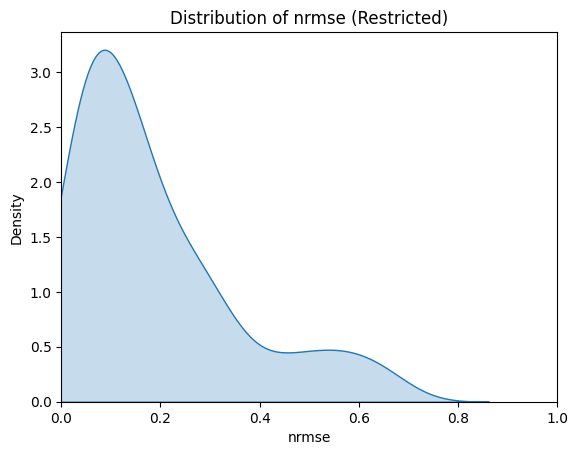

In [389]:
threshold = 1
restricted_nrmse = sorted_df_xgb2['nrmse'].apply(lambda x: min(x, threshold))

# 표준분포 곡선 그리기
sns.kdeplot(data=restricted_nrmse, shade=True)
plt.xlabel('nrmse')
plt.ylabel('Density')
plt.title('Distribution of nrmse (Restricted)')
plt.xlim(0, threshold)  # x축 범위 설정
plt.show()

C:\Users\junsuk\AppData\Local\Temp\ipykernel_10232\1634940302.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=restricted_nrmse, shade=True)


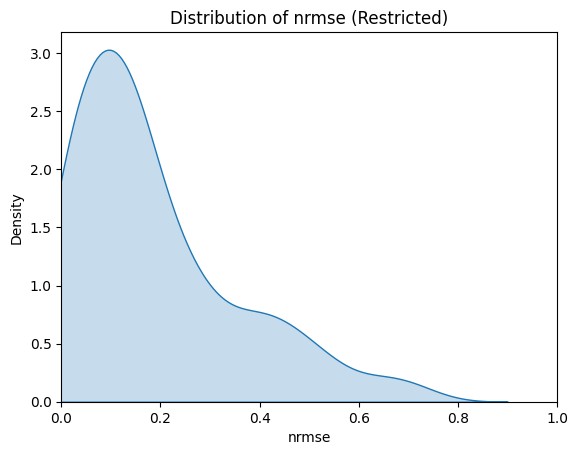

In [390]:
threshold = 1
restricted_nrmse = sorted_df_cat2['nrmse'].apply(lambda x: min(x, threshold))

# 표준분포 곡선 그리기
sns.kdeplot(data=restricted_nrmse, shade=True)
plt.xlabel('nrmse')
plt.ylabel('Density')
plt.title('Distribution of nrmse (Restricted)')
plt.xlim(0, threshold)  # x축 범위 설정
plt.show()

In [391]:
sorted_df_xgb2.to_csv('predicted_2303_fillzero_featurescout_0607.csv', index=False)

In [392]:
sorted_df_cat2.to_csv('predicted_2303_fillzero_cat_featurescout_0607.csv', index=False)

In [324]:
nrmse_over10_list1 = sorted_df_xgb2[sorted_df_xgb2['nrmse']>=0.2]

## 2. 전체 데이터중 21년 데이터까지 학습시켜 22년 1월부터 예측  

21년도 까지의 데이터로 22년 1월을 예측, 이후 예측한 값을 추가로 학습데이터로 추가하여 22년 2월 예측, 3월 예측 등등으로 해서
23년 3월까지 예측

In [326]:
cols1 = ['year','month','fabric','etc','GDP','industry','industrial','1m_qty','2m_qty','3m_mean','6m_mean','ly_qty','ly_3m_qty', 'qty']

df_xgb3 = pd.DataFrame(columns=['primaryItemId', 'actual', 'pred', 'nrmse', 'date'])

# 전체 데이터를 사용하여 학습
end_date = datetime(2022,1,1)
valend_date = datetime(2021,10,1)
end_date2 = datetime(2022,2,1)
valend_date2 = datetime(2021,11,1)
end_date3 = datetime(2022,3,1)
valend_date3 = datetime(2021,12,1)
end_date4 = datetime(2022,4,1)
valend_date4 = datetime(2022,1,1)
end_date5 = datetime(2022,5,1)
valend_date5 = datetime(2022,2,1)
end_date6 = datetime(2022,6,1)
valend_date6 = datetime(2022,3,1)
end_date7 = datetime(2022,7,1)
valend_date7 = datetime(2022,4,1)
end_date8 = datetime(2022,8,1)
valend_date8 = datetime(2022,5,1)
end_date9 = datetime(2022,9,1)
valend_date9 = datetime(2022,6,1)
end_date10 = datetime(2022,10,1)
valend_date10 = datetime(2022,7,1)
end_date11 = datetime(2022,11,1)
valend_date11 = datetime(2022,8,1)
end_date12 = datetime(2022,12,1)
valend_date12 = datetime(2022,9,1)
end_date13 = datetime(2023,1,1)


In [327]:
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date, valend_date, end_date2, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date2, valend_date2, end_date3, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date3, valend_date3, end_date4, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date4, valend_date4, end_date5, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date5, valend_date5, end_date6, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date6, valend_date6, end_date7, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date7, valend_date7, end_date8, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date8, valend_date8, end_date9, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date9, valend_date9, end_date10, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date10, valend_date10, end_date11, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date11, valend_date11, end_date12, df_xgb3, cols1)
df_xgb3 = xgboost_month(df_scaled, df_grouped, df_grouped_raw,end_date12, valend_date12, end_date13, df_xgb3, cols1)

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with scikit-learn, use `early_stopping_rounds` in constructor or`set_params` instead.
  warnings.warn(
C:\Users\junsuk\miniconda3\envs\eemd\lib\site-packages\xgboost\sklearn.py:835: UserWarning: `early_stopping_rounds` in `fit` method is deprecated for better compatibility with sc

In [328]:
df_xgb3

,primaryItemId,actual,pred,nrmse,date,scale_actual,scale_pred
0,2KPHSY0010,90000.0,46292.414062,0.485370,2022-01-31,0.999445,0.514075
1,2KPKRI0010,45000.0,59650.351562,0.075130,2022-01-31,0.230769,0.305899
2,2KPKRI0080,57500.0,14797.052734,0.711716,2022-01-31,0.958333,0.246618
3,2KPLCC0010,72000.0,71342.570312,0.005465,2022-01-31,0.598504,0.593039
4,2KSSNF0072,7200.0,7482.289551,0.017534,2022-01-31,0.447205,0.464738
...,...,...,...,...,...,...,...
2357,2SWSSR0050,10372.0,8960.911133,0.068740,2022-12-31,0.505261,0.436521
2358,2SWTSC0020,6019.0,2758.880371,0.218800,2022-12-31,0.403960,0.185160
2359,2SWTSC0070,0.0,6575.452637,0.214114,2022-12-31,0.000000,0.214114
2360,2SWTSC0123,0.0,4238.841797,0.273615,2022-12-31,0.000000,0.273615


In [329]:
df_xgb3.to_csv('predicted_22_fillzero_0529.csv', index=False)

In [330]:
df_xgb3 = df_xgb3.set_index('date')

In [ ]:
error_2022 = pd.DataFrame(columns =['primaryItemId','nrmse'])


for item_id in df_xgb3['primaryItemId'].unique():
    df_item = df_xgb3[df_xgb3['primaryItemId'] == item_id]
    if len(df_item) ==1:
        nrmse = df_item['nrmse'].values
        result3 = pd.DataFrame({'primaryItemId': item_id, 'nrmse': nrmse}, index=[0])
        error_2022 = pd.concat([error_2022, result3], ignore_index=True)  
    plt.xlabel("Date", fontsize=9)
    plt.ylabel("qty", fontsize=9)
    plt.plot(df_item.index,df_item[['actual', 'pred']])
    # plt.legend()
    plt.title(f"Primary Item ID {item_id}")
    plt.legend()
    plt.show()
    pred = df_item['pred'].values
    actual = df_item['actual'].values
    rmse = np.sqrt(np.mean((pred - actual) ** 2))
    nrmse = rmse / (actual.max() - actual.min())
    result3 = pd.DataFrame({'primaryItemId': item_id, 'nrmse': nrmse}, index=[0])
    error_2022 = pd.concat([error_2022, result3], ignore_index=True)       

In [332]:
error_2022 = error_2022.sort_values(by='nrmse')
print(len(error_2022))
def filter_non_infinite_rows(df):
    filtered_df = df[~np.isinf(df['nrmse'])]
    return filtered_df
error_not_inf = filter_non_infinite_rows(error_2022)
print(error_not_inf['nrmse'].mean())
print(len(error_2022[error_2022['nrmse'] <=0.1]))

201
0.40525962080038974
0


C:\Users\junsuk\AppData\Local\Temp\ipykernel_10232\1646058466.py:5: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=restricted_nrmse, shade=True)


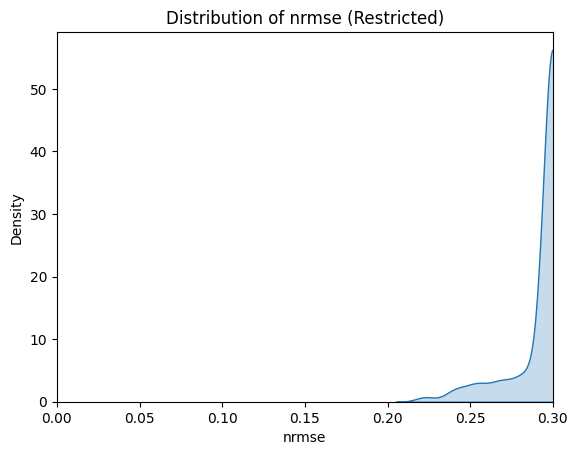

In [334]:
threshold = 0.3
restricted_nrmse = error_not_inf['nrmse'].apply(lambda x: min(x, threshold))

# 표준분포 곡선 그리기
sns.kdeplot(data=restricted_nrmse, shade=True)
plt.xlabel('nrmse')
plt.ylabel('Density')
plt.title('Distribution of nrmse (Restricted)')
plt.xlim(0, threshold)  # x축 범위 설정
plt.show()

In [335]:
error_2022.to_csv('predicted_22_combined_fillzero_0529.csv', index=False)

In [336]:
nrmse_over10_list2 = error_2022[error_2022['nrmse']>=0.1]

In [337]:
nrmse_over10_list2

,primaryItemId,nrmse
137,2SWINE0083,0.221946
20,2KVKUD0030,0.223693
67,2PEINO0064,0.236547
188,2SWSAY0230,0.240095
1,2KPKRI0010,0.240684
...,...,...
142,2SWINE0143,1.342826
154,2SWKHC0280,3.391473
167,2SWLCC1020,inf
134,2SWINE0055,inf


In [ ]:
#list1_id = ['2KVWAK0071','2SWSAY0240','2KVSAMO0600','2PELCC0060','2SWLXM0053']
for item_id in nrmse_over10_list2['primaryItemId'].unique():
    df_item = df_xgb3[df_xgb3['primaryItemId'] == item_id]
    plt.xlabel("Date", fontsize=9)
    plt.ylabel("qty", fontsize=9)
    #plt.plot(df_item.index,df_item['qty'])
    plt.plot(df_item.index,df_item[['actual', 'pred']])
    # plt.legend()
    plt.title(f"Primary Item ID {item_id}")
    plt.legend()
    plt.show()

In [ ]:
for item_id in nrmse_over10_list2['primaryItemId'].unique():
    df_item = df_raw_grouped[df_raw_grouped['primaryItemId'] == item_id]
    plt.xlabel("Date", fontsize=9)
    plt.ylabel("qty", fontsize=9)
    plt.plot(df_item.index,df_item['qty'])
    # plt.legend()
    plt.title(f"Primary Item ID {item_id}")
    plt.legend()
    plt.show()

음수 값 고려하는 작업 해보기 이상한 값들은 날려보내기  
+=가 같으면 그것은 주문 취소이므로 상쇄시키는 방법으로 진행
코드화 시켜서 자동화 -> 완료  
우선 문제점을 다 찾고 정상화 시켰음  
Catboost를 현재 있는 범주형 변수들을 적용해봤으나 나아지는 것은 없음  
데이터 선정을 12개월이 아닌 18개월 이상 가지고 있는 품목으로 한정 후 train 했더니 Catboost에서 조금 성능이 나아짐  
Feature scouting을 해와야 할 것 같음

### 추가한 Feature scouting
경제활동별 GDP 및 GNI(Quarterly, 단위=십억원)  
섬유 및 가전제품 제조업  
기타 제조업 및 산업용 장비 수리업  

Index of All Industry Production(Monthly, 단위: 2020년 = 100)  

### To do list
슬렉 코드 공유 결과 데이터 공유 - 완료  
데이터 최신 업데이트 - 완료  
외부 Feature 변수들 2~30개 뽑아서 Correlation진행  
상관관계 리스팅  
1차적으로 뽑아보고, 2차적으로 의미가 없어보이는 것들은 넣고 빼보고 하는 식으로 해서 유의미한 관계가 있을지 확인  
하이퍼파라미터 튜닝 자동화  
2022.04 ~ 2023.03 1년주기 예측  

#### Feature scouting3
Index of all industry production  
단위: 2020년 = 100, Monthly  

 Index of all industry production  
 Industrial production  
 Construction  
 Service Industry  
 Public administration  

#### Feature scouting4
2.1.2.1.1. 경제활동별 GDP 및 GNI(계절조정, 명목, 분기)  
단위: 십억원, Quarterly  
  제조업  
  섬유 및 가죽제품 제조업  
  목재, 종이, 인쇄 및 복제업  
  코크스 및 석유정제품 제조업  
  화학물질 및 화학제품 제조업  
  기타 제조업 및 산업용 장비 수리업  
총부가가치(기초가격)  
순생산물세  
국내총생산(시장가격, GDP)  
국민총소득(GNI)  

 
#### Feature scouting5
소비자 물가지수  
단위: 2020년 = 100, Monthly  

  식료품 및 비주류음료  
  의류 및 신발  
  오락 및 문화  
  기타 상품 및 서비스  

#### Feature scouting6
6.2.1. 소비자동향조사(전국, 월, 2008.9~)  
단위: CSI  
 - 소비자동향지수(CSI) = [(매우 좋아짐×1.0＋약간 좋아짐×0.5＋비슷함×0.0－약간 나빠짐×0.5－매우 나빠짐×1.0)/전체 응답 가구수×100]＋100  
 
  현재생활형편CSI  
  현재경기판단CSI  
  생활형편전망CSI  
  향후경기전망CSI  
  취업기회전망CSI  
  금리수준전망CSI  
  가계수입전망CSI  
  소비지출전망CSI  
    내구재 지출전망CSI  
    의류비 지출전망CSI  
    교양·오락·문화생활비 지출전망CSI  
  물가수준전망(1년후)CSI  
  임금수준전망CSI  
소비자심리지수  

